In [1]:
#importing libraries
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [3]:
#reading in data
data = pd.read_csv('hackathon_data/data.csv')
data.head()

,Unnamed: 0,route_id,trip_id,service_id,route,date,agency,arrival_time,departure_time,direction_id,...,trip_headsign,trip_short_name,pickup,drop_off,peak_offpeak,note,wheelchair_accessible,wheelchair_boarding,passenger_count,day_of_week
0,1,3,10000299,8433,New Haven,2020-05-22,Metro-North Railroad,00:25:00,00:25:00,0,...,Stamford,6300.0,True,True,0,Regular Station Stop,1,1,52,Friday
1,2,3,10000299,8433,New Haven,2020-05-22,Metro-North Railroad,01:11:00,01:11:00,0,...,Stamford,6300.0,True,True,0,Regular Station Stop,1,1,55,Friday
2,3,3,10000299,8433,New Haven,2020-05-22,Metro-North Railroad,01:14:00,01:14:00,0,...,Stamford,6300.0,True,True,0,Regular Station Stop,1,0,59,Friday
3,4,3,10000299,8433,New Haven,2020-05-22,Metro-North Railroad,01:18:00,01:18:00,0,...,Stamford,6300.0,True,True,0,Regular Station Stop,1,1,66,Friday
4,5,3,10000299,8433,New Haven,2020-05-22,Metro-North Railroad,01:21:00,01:21:00,0,...,Stamford,6300.0,True,True,0,Regular Station Stop,1,0,72,Friday


In [4]:
#merging date and time
datetime = data['date'] + ' ' + data['departure_time']

In [5]:
data['datetime'] = pd.to_datetime(datetime)
#time feature of model

In [6]:
data_updated = data[['datetime','passenger_count']]
data_updated.head()


,datetime,passenger_count
0,2020-05-22 00:25:00,52
1,2020-05-22 01:11:00,55
2,2020-05-22 01:14:00,59
3,2020-05-22 01:18:00,66
4,2020-05-22 01:21:00,72


In [7]:
data_updated.tail()

,datetime,passenger_count
2747140,2020-05-26 23:19:00,55
2747141,2020-05-26 23:30:00,59
2747142,2020-05-26 23:36:00,54
2747143,2020-05-26 23:56:00,70
2747144,2020-05-27 00:12:00,53


In [8]:
# from datetime import datetime
indexed_data = data_updated.set_index(['datetime'])
indexed_data.head()
# list(data['Month'])[-1]

,passenger_count
datetime,
2020-05-22 00:25:00,52
2020-05-22 01:11:00,55
2020-05-22 01:14:00,59
2020-05-22 01:18:00,66
2020-05-22 01:21:00,72


In [9]:
indexed_data.tail(24*7 + 1)

,passenger_count
datetime,
2020-05-26 15:56:00,187
2020-05-26 16:08:00,199
2020-05-26 12:38:00,207
2020-05-26 12:50:00,212
2020-05-26 13:02:00,193
...,...
2020-05-26 23:19:00,55
2020-05-26 23:30:00,59
2020-05-26 23:36:00,54


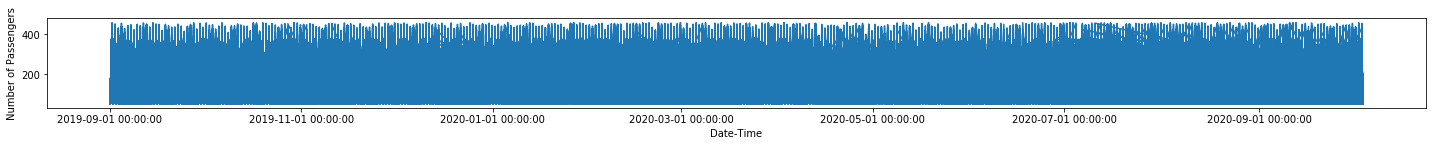

In [10]:
#printing seasonality in data
import matplotlib.dates as mdates
fig = plt.figure(figsize=(20, 2))
ax = fig.add_subplot(111)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
plt.xlabel('Date-Time')
plt.ylabel('Number of Passengers')
plt.plot(indexed_data,linestyle='solid')
plt.tight_layout()

In [10]:
# #checking for autocorrelation
# # autocorrelation
# print(sm.graphics.tsa.acf(indexed_data, nlags=40))
# # partial autocorrelation
# print(sm.graphics.tsa.acf(indexed_data, nlags=40))

In [11]:
# #ACF Plot
# sm.graphics.tsa.plot_acf(indexed_data, lags=40)
# plt.show()

In [12]:
# #PACF Plot
# sm.graphics.tsa.plot_pacf(indexed_data, lags=40)
# plt.show()

In [11]:
# Define the d and q parameters to take any value between 0 and 1
q = d = range(0, 2)
# Define the p parameters to take any value between 0 and 3
p = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 7)
SARIMAX: (0, 0, 1) x (0, 1, 0, 7)
SARIMAX: (0, 1, 0) x (0, 1, 1, 7)
SARIMAX: (0, 1, 0) x (1, 0, 0, 7)


In [12]:
train_data = indexed_data['2020-05-22 00:25:00':'2020-05-26 15:56:00']
test_data = indexed_data['2020-05-26 16:08:00':'2020-05-27 00:12:00']

In [13]:
#grid searching over all possible parameters
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

AIC = []
SARIMAX_model = []
counter = 0
for param in pdq:
    for param_seasonal in seasonal_pdq:
        counter += 1
        if(counter <= 10):
            try:
                mod = sm.tsa.statespace.SARIMAX(train_data,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()

                print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic), end='\r')
                AIC.append(results.aic)
                SARIMAX_model.append([param, param_seasonal])
            except:
                continue

In [14]:
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

The smallest AIC is 214123.8428881133 for model SARIMAX(0, 0, 0)x(2, 0, 1, 7)


In [15]:
# Let's fit this model with the best params
mod = sm.tsa.statespace.SARIMAX(train_data,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

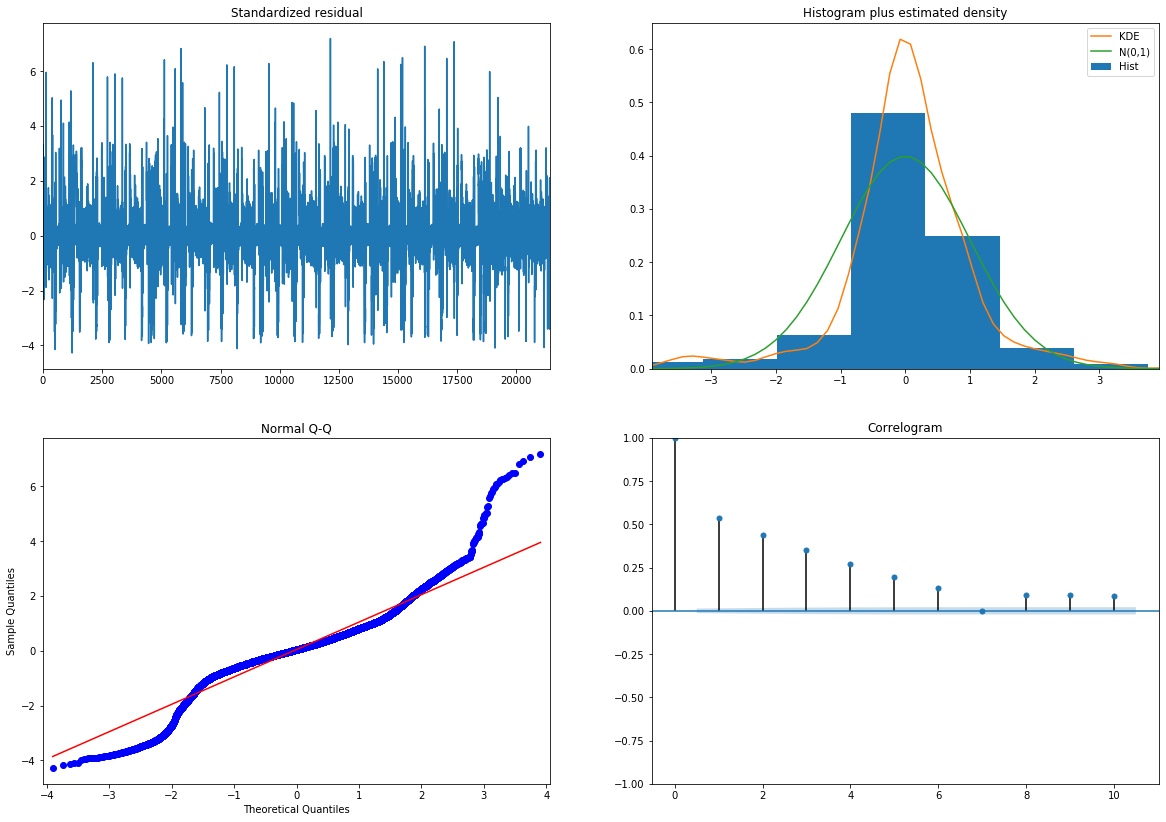

In [16]:
#residuals are normal
results.plot_diagnostics(figsize=(20, 14))
plt.show()

In [ ]:
#table to return
table = []

In [ ]:
#predict count of passengers
pred0 = results.get_prediction(start='2020-05-18 00:00:00', dynamic=False) #monday
pred0_ci = pred0.conf_int()
table.append(pred0.predicted_mean[2:8 + 24*7])

In [18]:
#predict count of passengers
pred1 = results.get_prediction(start='2020-05-19 00:00:00', dynamic=False) #tuesday
pred1_ci = pred1.conf_int()
# table.append(pred1.predicted_mean)
table.append(pred1.predicted_mean[2:8 + 24*7])

In [19]:
#predict count of passengers
pred2 = results.get_prediction(start='2020-05-20 00:00:00', dynamic=False) #wednesday
pred2_ci = pred1.conf_int()
# table.append(pred2.predicted_mean)
table.append(pred2.predicted_mean[2:8 + 24*7])

In [ ]:
#predict count of passengers
pred3 = results.get_prediction(start='2020-05-21 00:00:00', dynamic=False) #thursday
pred3_ci = pred1.conf_int()
# table.append(pred3.predicted_mean)
table.append(pred3.predicted_mean[2:8 + 24*7])

In [ ]:
#predict count of passengers
pred4 = results.get_prediction(start='2020-05-22 00:00:00', dynamic=False) #friday
pred4_ci = pred1.conf_int()
# table.append(pred4.predicted_mean)
table.append(pred4.predicted_mean[2:8 + 24*7])

In [ ]:
#predict count of passengers
pred5 = results.get_prediction(start='2020-05-23 00:00:00', dynamic=False) #sat
pred5_ci = pred1.conf_int()
# table.append(pred5.predicted_mean)
table.append(pred5.predicted_mean[2:8 + 24*7])

In [ ]:
#predict count of passengers
pred6 = results.get_prediction(start='2020-05-24 00:00:00', dynamic=False) #sun
pred6_ci = pred1.conf_int()
# table.append(pred6.predicted_mean)
table.append(pred6.predicted_mean[2:8 + 24*7])

In [25]:
pred0.predicted_mean

datetime
2020-05-22 01:21:00      0.000000
2020-05-22 01:24:00      0.000000
2020-05-22 01:27:00      0.000000
2020-05-22 01:47:00     53.224669
2020-05-22 00:35:00     56.253308
                          ...    
2020-05-26 13:44:00    147.612848
2020-05-26 13:50:00    140.071986
2020-05-26 14:10:00    138.720520
2020-05-26 14:26:00    154.439211
2020-05-26 15:54:00    172.636985
Length: 21439, dtype: float64